<a href="https://colab.research.google.com/github/SiriuXProtocoL/Fake-News-LSTM-/blob/main/FakeNewsClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fake News Classification

- The quick spread of fake news has the potential for calamitous impacts on individuals and society. For example, the most popular fake news was more widely spread on Facebook than the most popular authentic mainstream news during the U.S. 2016 president election. Therefore, fake news detection on social media has attracted increasing attention from researchers to politicians.

####Importing

In [1]:
!pip install --upgrade tensorflow-gpu==2.0
!pip install plotly
!pip install --upgrade nbformat
!pip install nltk
!pip install spacy # spaCy is an open-source software library for advanced natural language processing
!pip install WordCloud
!pip install gensim # Gensim is an open-source library for unsupervised topic modeling and natural language processing

     |████████████████████████████████| 380.8MB 43kB/s 
     |████████████████████████████████| 3.8MB 57.9MB/s 
     |████████████████████████████████| 51kB 7.6MB/s 
     |████████████████████████████████| 450kB 52.6MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=c59f4619b164e7c1c02a09834043c55e4f5d3081b7cbdef531c1c440ab2a1266
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.3.0 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement tensorboard<3,>=2.3.0, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement tensorflow-estimator<2.4.0,>=2.3.0, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing ins

In [2]:

import nltk
nltk.download('punkt')

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

# import keras
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional
from tensorflow.keras.models import Model

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


####Loading the Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
cd /content/drive/My Drive/DataSets/Fake_News/

/content/drive/My Drive/DataSets/Fake_News


In [5]:
# load the data
df_true = pd.read_csv("True.csv")
df_fake = pd.read_csv("Fake.csv")

####Descriptive Statistics

In [6]:
df_true.isna().sum()

title      0
text       0
subject    0
date       0
dtype: int64

- we dont have any null values in the True class

In [7]:
df_fake.isna().sum()

title      0
text       0
subject    0
date       0
dtype: int64

- We dont have any null class in the Fake class

In [8]:
df_true.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [9]:
df_fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


- The dataset consists of Title, Text, Subject, and date column
- The true class occupies around 669.4 kB in memory
- The flase class occupies around 773.9 kB in memory

#EDA

####Adding a label Class

In [10]:
# add a target class column to indicate whether the news is real or fake
df_true['isfake'] = 1
df_true.head()

title  ... isfake
0  As U.S. budget fight looms, Republicans flip t...  ...      1
1  U.S. military to accept transgender recruits o...  ...      1
2  Senior U.S. Republican senator: 'Let Mr. Muell...  ...      1
3  FBI Russia probe helped by Australian diplomat...  ...      1
4  Trump wants Postal Service to charge 'much mor...  ...      1

[5 rows x 5 columns]

- We add a new column called isfake 
- In true class 1 indicates true news

In [11]:
df_fake['isfake'] = 0
df_fake.head()

title  ... isfake
0   Donald Trump Sends Out Embarrassing New Year’...  ...      0
1   Drunk Bragging Trump Staffer Started Russian ...  ...      0
2   Sheriff David Clarke Becomes An Internet Joke...  ...      0
3   Trump Is So Obsessed He Even Has Obama’s Name...  ...      0
4   Pope Francis Just Called Out Donald Trump Dur...  ...      0

[5 rows x 5 columns]

- We add a new column called isfake to the fake news dataset also
- In true class 0 indicates fake news

In [12]:
# Concatenate Real and Fake News
df = pd.concat([df_true, df_fake]).reset_index(drop = True)
df

title  ... isfake
0      As U.S. budget fight looms, Republicans flip t...  ...      1
1      U.S. military to accept transgender recruits o...  ...      1
2      Senior U.S. Republican senator: 'Let Mr. Muell...  ...      1
3      FBI Russia probe helped by Australian diplomat...  ...      1
4      Trump wants Postal Service to charge 'much mor...  ...      1
...                                                  ...  ...    ...
44893  McPain: John McCain Furious That Iran Treated ...  ...      0
44894  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...  ...      0
44895  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...  ...      0
44896  How to Blow $700 Million: Al Jazeera America F...  ...      0
44897  10 U.S. Navy Sailors Held by Iranian Military ...  ...      0

[44898 rows x 5 columns]

- Now we combine the two datasets together

In [13]:
df.drop(columns = ['date'], inplace = True)

- we are dropping the date column

In [14]:
# combine title and text together
df['original'] = df['title'] + ' ' + df['text']
df.head()

title  ...                                           original
0  As U.S. budget fight looms, Republicans flip t...  ...  As U.S. budget fight looms, Republicans flip t...
1  U.S. military to accept transgender recruits o...  ...  U.S. military to accept transgender recruits o...
2  Senior U.S. Republican senator: 'Let Mr. Muell...  ...  Senior U.S. Republican senator: 'Let Mr. Muell...
3  FBI Russia probe helped by Australian diplomat...  ...  FBI Russia probe helped by Australian diplomat...
4  Trump wants Postal Service to charge 'much mor...  ...  Trump wants Postal Service to charge 'much mor...

[5 rows x 5 columns]

- title column and the text column is combined together for better analysis

In [15]:
df['original'][0]

'As U.S. budget fight looms, Republicans flip their fiscal script WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non

#Preprocessing

####Removing the Stopwords

In [16]:
# download stopwords
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [17]:
# Obtain additional stopwords from nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

- Additional stopwords are added into the existing stopword list

In [18]:
# Remove stopwords and remove words with 2 or less characters
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
            result.append(token)
            
    return result

- Now we remove stopwords and remove words with 2 or less characters

In [19]:
# Apply the function to the dataframe
df['clean'] = df['original'].apply(preprocess)

- The changes are applied to the Data

In [20]:
# Show original news
df['original'][0]

'As U.S. budget fight looms, Republicans flip their fiscal script WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non

In [21]:
# Show cleaned up news after removing stopwords
print(df['clean'][0])

['budget', 'fight', 'looms', 'republicans', 'flip', 'fiscal', 'script', 'washington', 'reuters', 'head', 'conservative', 'republican', 'faction', 'congress', 'voted', 'month', 'huge', 'expansion', 'national', 'debt', 'cuts', 'called', 'fiscal', 'conservative', 'sunday', 'urged', 'budget', 'restraint', 'keeping', 'sharp', 'pivot', 'republicans', 'representative', 'mark', 'meadows', 'speaking', 'face', 'nation', 'drew', 'hard', 'line', 'federal', 'spending', 'lawmakers', 'bracing', 'battle', 'january', 'return', 'holidays', 'wednesday', 'lawmakers', 'begin', 'trying', 'pass', 'federal', 'budget', 'fight', 'likely', 'linked', 'issues', 'immigration', 'policy', 'november', 'congressional', 'election', 'campaigns', 'approach', 'republicans', 'seek', 'control', 'congress', 'president', 'donald', 'trump', 'republicans', 'want', 'budget', 'increase', 'military', 'spending', 'democrats', 'want', 'proportional', 'increases', 'defense', 'discretionary', 'spending', 'programs', 'support', 'educati

In [22]:
df

title  ...                                              clean
0      As U.S. budget fight looms, Republicans flip t...  ...  [budget, fight, looms, republicans, flip, fisc...
1      U.S. military to accept transgender recruits o...  ...  [military, accept, transgender, recruits, mond...
2      Senior U.S. Republican senator: 'Let Mr. Muell...  ...  [senior, republican, senator, mueller, washing...
3      FBI Russia probe helped by Australian diplomat...  ...  [russia, probe, helped, australian, diplomat, ...
4      Trump wants Postal Service to charge 'much mor...  ...  [trump, wants, postal, service, charge, amazon...
...                                                  ...  ...                                                ...
44893  McPain: John McCain Furious That Iran Treated ...  ...  [mcpain, john, mccain, furious, iran, treated,...
44894  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...  ...  [justice, yahoo, settles, mail, privacy, class...
44895  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...  ...  [sunnistan, allied, safe, zone, plan, territor...
44896  How to Blow $700 Million: Al Jazeera America F...  ...  [blow, million, jazeera, america, finally, cal...
44897  10 U.S. Navy Sailors Held by Iranian Military ...  ...  [navy, sailors, held, iranian, military, signs...

[44898 rows x 6 columns]

In [23]:
# Obtain the total words present in the dataset
list_of_words = []
for i in df.clean:
    for j in i:
        list_of_words.append(j)


- Applying Tokenization

In [24]:
list_of_words

['budget',
 'fight',
 'looms',
 'republicans',
 'flip',
 'fiscal',
 'script',
 'washington',
 'reuters',
 'head',
 'conservative',
 'republican',
 'faction',
 'congress',
 'voted',
 'month',
 'huge',
 'expansion',
 'national',
 'debt',
 'cuts',
 'called',
 'fiscal',
 'conservative',
 'sunday',
 'urged',
 'budget',
 'restraint',
 'keeping',
 'sharp',
 'pivot',
 'republicans',
 'representative',
 'mark',
 'meadows',
 'speaking',
 'face',
 'nation',
 'drew',
 'hard',
 'line',
 'federal',
 'spending',
 'lawmakers',
 'bracing',
 'battle',
 'january',
 'return',
 'holidays',
 'wednesday',
 'lawmakers',
 'begin',
 'trying',
 'pass',
 'federal',
 'budget',
 'fight',
 'likely',
 'linked',
 'issues',
 'immigration',
 'policy',
 'november',
 'congressional',
 'election',
 'campaigns',
 'approach',
 'republicans',
 'seek',
 'control',
 'congress',
 'president',
 'donald',
 'trump',
 'republicans',
 'want',
 'budget',
 'increase',
 'military',
 'spending',
 'democrats',
 'want',
 'proportional',
 '

In [25]:
len(list_of_words)

9277072

- Total number of words in the dataset : 9277072

In [26]:
# Obtain the total number of unique words
total_words = len(list(set(list_of_words)))
total_words

108705

- Total number of Unique words : 108705

In [27]:
# join the words into a string
df['clean_joined'] = df['clean'].apply(lambda x: " ".join(x))

- Now we join the tokenized words without the stopwords together into a new column cleaned_joined

In [28]:
df

title  ...                                       clean_joined
0      As U.S. budget fight looms, Republicans flip t...  ...  budget fight looms republicans flip fiscal scr...
1      U.S. military to accept transgender recruits o...  ...  military accept transgender recruits monday pe...
2      Senior U.S. Republican senator: 'Let Mr. Muell...  ...  senior republican senator mueller washington r...
3      FBI Russia probe helped by Australian diplomat...  ...  russia probe helped australian diplomat washin...
4      Trump wants Postal Service to charge 'much mor...  ...  trump wants postal service charge amazon shipm...
...                                                  ...  ...                                                ...
44893  McPain: John McCain Furious That Iran Treated ...  ...  mcpain john mccain furious iran treated sailor...
44894  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...  ...  justice yahoo settles mail privacy class actio...
44895  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...  ...  sunnistan allied safe zone plan territorial bo...
44896  How to Blow $700 Million: Al Jazeera America F...  ...  blow million jazeera america finally calls qui...
44897  10 U.S. Navy Sailors Held by Iranian Military ...  ...  navy sailors held iranian military signs neoco...

[44898 rows x 7 columns]

In [29]:
df['clean_joined'][0]

'budget fight looms republicans flip fiscal script washington reuters head conservative republican faction congress voted month huge expansion national debt cuts called fiscal conservative sunday urged budget restraint keeping sharp pivot republicans representative mark meadows speaking face nation drew hard line federal spending lawmakers bracing battle january return holidays wednesday lawmakers begin trying pass federal budget fight likely linked issues immigration policy november congressional election campaigns approach republicans seek control congress president donald trump republicans want budget increase military spending democrats want proportional increases defense discretionary spending programs support education scientific research infrastructure public health environmental protection trump administration willing going increase defense discretionary spending percent meadows chairman small influential house freedom caucus said program democrats saying need government raise 

In [30]:
#Perform sanity check on the prepocessing stage by visualizing at least 3 sample news 
df['original'][5]
df['clean_joined'][5]

'white house congress prepare talks spending immigration west palm beach washington reuters white house said friday kick talks week republican democratic congressional leaders immigration policy government spending issues need wrapped early year expected flurry legislative activity comes republicans democrats begin stage midterm congressional elections november president donald trump republican party eager maintain control congress democrats look openings wrest seats away senate house representatives wednesday trump budget chief mick mulvaney legislative affairs director marc short meet senate majority leader mitch mcconnell house speaker paul ryan republicans democratic counterparts senator chuck schumer representative nancy pelosi white house said followed weekend strategy sessions trump mcconnell ryan camp david presidential retreat maryland according white house senate returns work house congress passed short term government funding week taking christmas break needs come agreement 

# EDA After Preprocessing

####Histograms

In [ ]:
df

title  ...                                       clean_joined
0      As U.S. budget fight looms, Republicans flip t...  ...  budget fight looms republicans flip fiscal scr...
1      U.S. military to accept transgender recruits o...  ...  military accept transgender recruits monday pe...
2      Senior U.S. Republican senator: 'Let Mr. Muell...  ...  senior republican senator mueller washington r...
3      FBI Russia probe helped by Australian diplomat...  ...  russia probe helped australian diplomat washin...
4      Trump wants Postal Service to charge 'much mor...  ...  trump wants postal service charge amazon shipm...
...                                                  ...  ...                                                ...
44893  McPain: John McCain Furious That Iran Treated ...  ...  mcpain john mccain furious iran treated sailor...
44894  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...  ...  justice yahoo settles mail privacy class actio...
44895  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...  ...  sunnistan allied safe zone plan territorial bo...
44896  How to Blow $700 Million: Al Jazeera America F...  ...  blow million jazeera america finally calls qui...
44897  10 U.S. Navy Sailors Held by Iranian Military ...  ...  navy sailors held iranian military signs neoco...

[44898 rows x 7 columns]

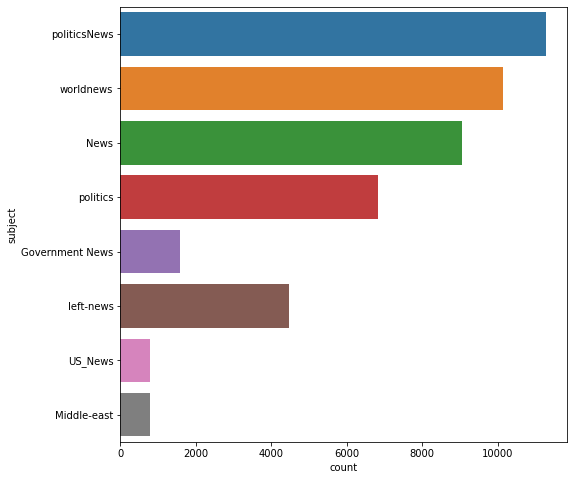

In [ ]:
# plot the number of samples in 'subject'
plt.figure(figsize = (8, 8))
sns.countplot(y = "subject", data = df)

- Political News has the maximun number of news
- Middle East and US News has an almost similar count

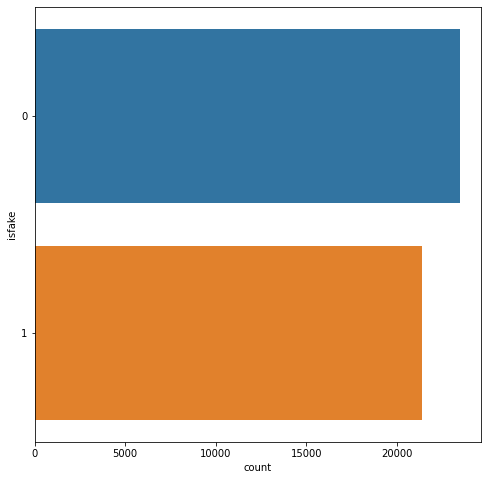

In [ ]:
# plot the number of samples in 'isfake'
plt.figure(figsize = (8, 8))
sns.countplot(y = "isfake", data = df)

- We can see an almost balanced distribution of both the real and fake news

####Word Cloud

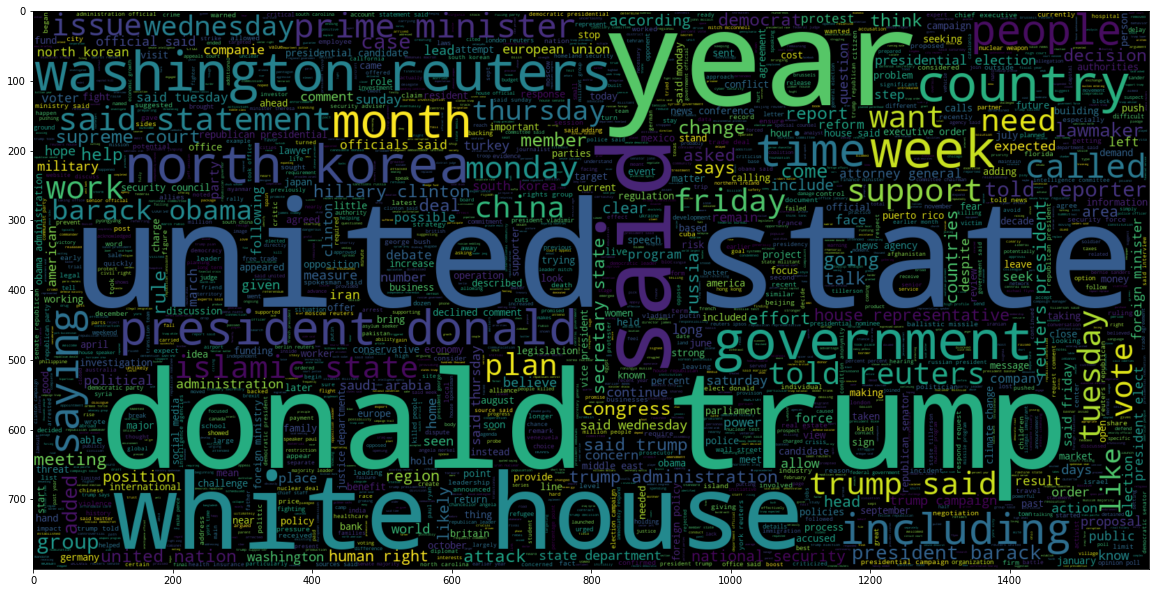

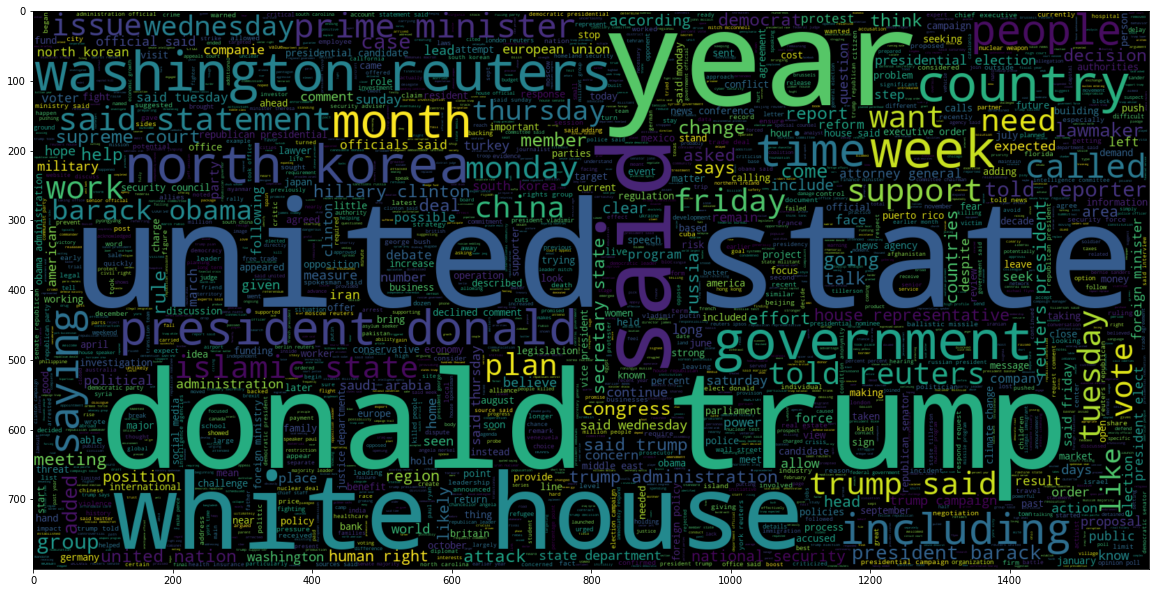

In [ ]:
# plot the word cloud for text that is Real
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.isfake == 1].clean_joined))
plt.imshow(wc, interpolation = 'bilinear')

- Word Cloud for the Real News has
  - Donald Trumb
  - white house
  - said
  - United States 
  - Year 
  - Month

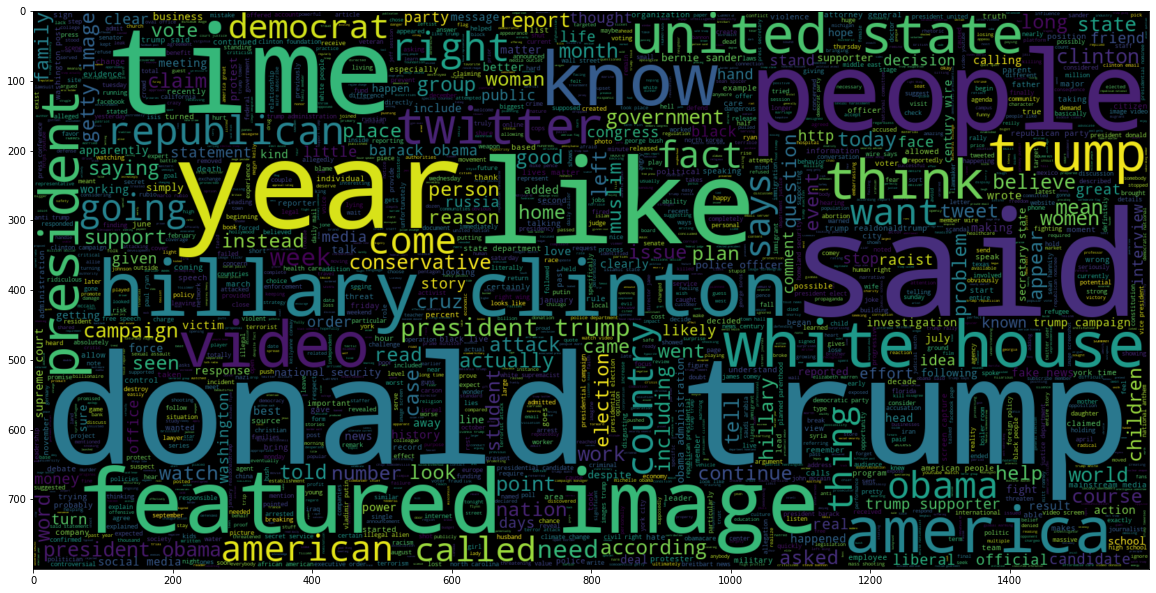

In [31]:
# plot the word cloud for text that is Fake
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.isfake == 0].clean_joined))
plt.imshow(wc, interpolation = 'bilinear')

- Word Cloud for fake news has
  - Donald Trump
  - said
  - year
  - clinton
  - like
  - time

In [32]:
# length of maximum document will be needed to create word embeddings 
maxlen = -1
for doc in df.clean_joined:
    tokens = nltk.word_tokenize(doc)
    if(maxlen<len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in any document is =", maxlen)

The maximum number of words in any document is = 4406


- The maximum number of words in any document is = 4406


####Distribution Plot

In [ ]:
# visualize the distribution of number of words in a text
import plotly.express as px
fig = px.histogram(x = [len(nltk.word_tokenize(x)) for x in df.clean_joined], nbins = 100)
fig.show()

- visualizing the distribution of number of words in a text shows a left sqeued normal distribution of words

#Applying Tokenization and Padding

####Train Test Split

In [ ]:
# split data into test and train 
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.clean_joined, df.isfake, test_size = 0.2)

- We split the data into 80% training and 20% testing

####Tokenization

In [ ]:
from nltk import word_tokenize

In [ ]:
# Create a tokenizer to tokenize the words and create sequences of tokenized words
tokenizer = Tokenizer(num_words = total_words)
tokenizer.fit_on_texts(x_train)
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)


- Now we create a tokenizer to tokenize the words and create sequences of tokenized words

####Encoding 

In [ ]:
print("The encoding for document\n",df.clean_joined[0],"\n is : ",train_sequences[0])

The encoding for document
 budget fight looms republicans flip fiscal script washington reuters head conservative republican faction congress voted month huge expansion national debt cuts called fiscal conservative sunday urged budget restraint keeping sharp pivot republicans representative mark meadows speaking face nation drew hard line federal spending lawmakers bracing battle january return holidays wednesday lawmakers begin trying pass federal budget fight likely linked issues immigration policy november congressional election campaigns approach republicans seek control congress president donald trump republicans want budget increase military spending democrats want proportional increases defense discretionary spending programs support education scientific research infrastructure public health environmental protection trump administration willing going increase defense discretionary spending percent meadows chairman small influential house freedom caucus said program democrats say

- We encode the words into numbers

####padding

In [ ]:
padded_train = pad_sequences(train_sequences,maxlen = 40, padding = 'post', truncating = 'post')
padded_test = pad_sequences(test_sequences,maxlen = 40, truncating = 'post') 

- Add padding can either be maxlen = 4406 or smaller number maxlen = 40 seems to work well based on results as we have the maximun word as 4406 and minimun word count as 40

In [ ]:
for i,doc in enumerate(padded_train[:2]):
     print("The padded encoding for document",i+1," is : ",doc)

The padded encoding for document 1  is :  [   49  1012    93    47   559  1002    73    25     9    13   231    49
  1012    93    47    73   546   559  1002   221    65   155   249   439
   775   379   105  6846  3471     2   169  1002    13 13040  7819   579
   268  2338  1606     3]
The padded encoding for document 2  is :  [  265    33   822  3382  1154   881   279   265    33   161   159  4309
   108  3321    10     1   139   364   184   133  1186  3367  5690  3923
  2334  2369  5840   881    33    17    12    37   614  4577  5291   860
     5 24115   100  4171]


- Padding is applied to the Dataset

#Build and Train the LSTM Model

####Building the model

In [ ]:
# Sequential Model
model = Sequential()

# embeddidng layer
model.add(Embedding(total_words, output_dim = 128))
# model.add(Embedding(total_words, output_dim = 240))


# Bi-Directional RNN and LSTM
model.add(Bidirectional(LSTM(128)))

# Dense layers
model.add(Dense(128, activation = 'relu'))
model.add(Dense(1,activation= 'sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         13914240  
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               263168    
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 14,210,433
Trainable params: 14,210,433
Non-trainable params: 0
_________________________________________________________________


In [ ]:
total_words

108705

- we have 108705 total words

In [ ]:
y_train = np.asarray(y_train)

###Training the Model

In [ ]:
# train the model
model.fit(padded_train, y_train, batch_size = 64, validation_split = 0.1, epochs = 2)

Train on 32326 samples, validate on 3592 samples
Epoch 1/2
32326/32326 [==============================] - 94s 3ms/sample - loss: 0.0391 - acc: 0.9865 - val_loss: 0.0179 - val_acc: 0.9972
Epoch 2/2
32326/32326 [==============================] - 83s 3ms/sample - loss: 0.0011 - acc: 0.9997 - val_loss: 0.0195 - val_acc: 0.9975


- We train the model for 2 Epochs

#Evaluation


###Making predictions

In [ ]:
# make prediction
pred = model.predict(padded_test)

####Testing predictions

In [ ]:
padded_test

array([[ 5946,   297,  1973, ...,  9950,   177,   476],
       [  101,  1039,   117, ...,   101,   327,   449],
       [  930,    13,   207, ...,    34,  2191,   670],
       ...,
       [   15,     8,    46, ...,   208,   904,   915],
       [ 1948,   319,  3237, ...,   234,   946,  3079],
       [    0,     0,     0, ...,   299,  3625, 90956]], dtype=int32)

In [ ]:
a = model.predict( [5946,   297,  1973,  9950,   177,   476])

In [ ]:
a

array([[0.42261612],
       [0.47069034],
       [0.43855202],
       [0.53423405],
       [0.47654846],
       [0.54166144]], dtype=float32)

- Testing for a manual sequence

In [ ]:
# if the predicted value is >0.5 it is real else it is fake
prediction = []
for i in range(len(pred)):
    if pred[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)

###Model Accuracy

In [ ]:
# getting the accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(list(y_test), prediction)

print("Model Accuracy : ", accuracy)

Model Accuracy :  0.9909799554565701


Model Accuracy :  0.9909799554565701

#####Confusion Matrix

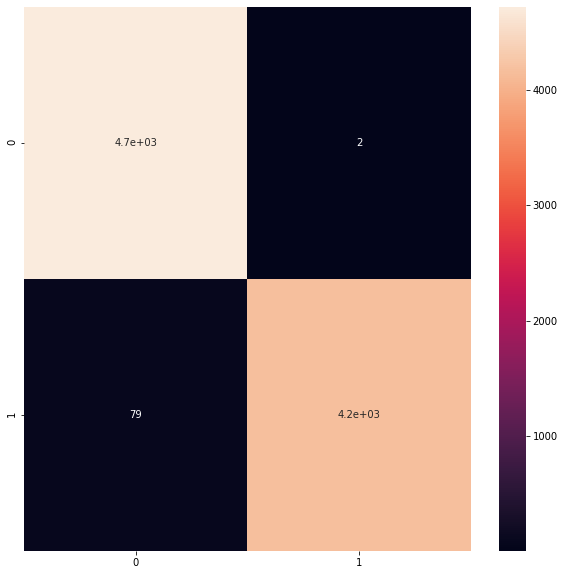

In [ ]:
# get the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(list(y_test), prediction)
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True)

- The confusion matrix has 2 records as False negatives and 79 records as True Positives

In [ ]:
# category dict
category = { 0: 'Fake News', 1 : "Real News"}

#Conclusion
  - This Fake news classification technique can be applied by online social media platforms to filter the Real news from thr fake ones so as to have a firm customer relationship and to retain and inform customers with good quality news